# Imports and data loading

In [7]:
#pip install imblearn
#pip install aif360

In [8]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
import plotly.offline as py
import xgboost as xgb
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import EqOddsPostprocessing

pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


In [10]:
df = pd.read_csv('loans_clean.csv')
df.shape

(4993, 292)

# Train test split

In [11]:
# Split the data into training and validation sets (80% training, 20% validation)
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)
X_train = train_data.drop('status', axis=1)
y_train = train_data['status']
X_val = val_data.drop('status', axis=1)
y_val = val_data['status']

In [12]:
X_train.shape

(3994, 291)

# SMOTE

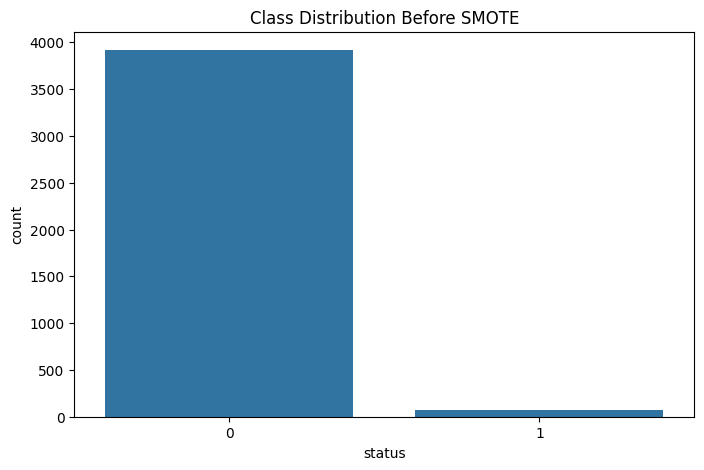

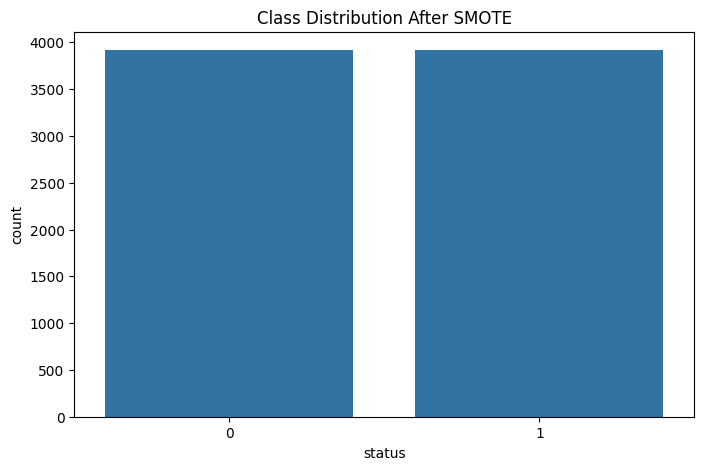

In [13]:
# Class distribution before SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title('Class Distribution Before SMOTE')
plt.show()

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled)
plt.title('Class Distribution After SMOTE')
plt.show()

In [14]:
# Class distribution before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# Class distribution after SMOTE
print("\nClass distribution after SMOTE:")
print(y_resampled.value_counts())

Class distribution before SMOTE:
0    3917
1      77
Name: status, dtype: int64

Class distribution after SMOTE:
0    3917
1    3917
Name: status, dtype: int64


# Reweighing

In [15]:
# Reassemble X_train and y_train
resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
resampled_df['status'] = y_resampled

<ipython-input-15-22dce51e08fb>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [16]:
# Indicate standard dataset
dataset = StandardDataset(resampled_df, label_name='status', favorable_classes=[0], protected_attribute_names=['borrowers.gender'], privileged_classes=[[1]])

# Initialize the Reweighing algorithm
unprivileged_groups = [{'borrowers.gender': 0}]  # assuming 0 corresponds to the unprivileged group
privileged_groups = [{'borrowers.gender': 1}]    # assuming 1 corresponds to the privileged group
reweighing = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Apply reweighing to the resampled training set
train_reweighted = reweighing.fit_transform(dataset)

In [17]:
# Re-split X and y
X_train_reweighted = train_reweighted.features
y_train_reweighted = train_reweighted.labels.ravel()

In [18]:
# convert back to pd df
# Convert features back to a pandas DataFrame
X_train = pd.DataFrame(X_train_reweighted, columns=train_reweighted.feature_names)

# Convert labels back to a pandas Series
y_train = pd.Series(y_train_reweighted, name=train_reweighted.label_names[0])

# Dropping sensitive and irrelevant features after SMOTE and Reweighing

In [19]:
# drop irrelevant columns
# list of columns to drop
columns_to_drop = ['borrowers.gender','description.languages_en','description.languages_es',
                   'description.languages_fr','description.languages_ru', 'description.languages_id',
                   'location.country_Afghanistan','location.country_Armenia','location.country_Azerbaijan',
                   'location.country_Benin','location.country_Bolivia','location.country_Bosnia and Herzegovina',
                   'location.country_Bulgaria','location.country_Cambodia','location.country_Cameroon',
                   'location.country_Costa Rica','location.country_Cote D\'Ivoire','location.country_Dominican Republic',
                   'location.country_Ecuador','location.country_El Salvador','location.country_Gaza',
                   'location.country_Ghana','location.country_Guatemala','location.country_Haiti',
                   'location.country_Honduras','location.country_Indonesia','location.country_Iraq',
                   'location.country_Kenya','location.country_Kyrgyzstan','location.country_Lebanon',
                   'location.country_Liberia','location.country_Mali','location.country_Mexico',
                   'location.country_Moldova','location.country_Mongolia','location.country_Mozambique',
                   'location.country_Nepal','location.country_Nicaragua','location.country_Nigeria',
                   'location.country_Pakistan','location.country_Palestine','location.country_Paraguay',
                   'location.country_Peru','location.country_Philippines','location.country_Rwanda',
                   'location.country_Samoa','location.country_Senegal','location.country_Sierra Leone',
                   'location.country_South Sudan','location.country_Tajikistan','location.country_Tanzania',
                   'location.country_The Democratic Republic of the Congo','location.country_Togo','location.country_Uganda',
                   'location.country_Ukraine','location.country_United States','location.country_Viet Nam',
                   'terms.disbursal_currency_AFN','terms.disbursal_currency_AMD','terms.disbursal_currency_AZN',
                   'terms.disbursal_currency_BAM','terms.disbursal_currency_BGN','terms.disbursal_currency_BOB',
                   'terms.disbursal_currency_CRC','terms.disbursal_currency_DOP','terms.disbursal_currency_GHS',
                   'terms.disbursal_currency_GTQ','terms.disbursal_currency_HNL','terms.disbursal_currency_HTG',
                   'terms.disbursal_currency_IDR','terms.disbursal_currency_IQD','terms.disbursal_currency_KES',
                   'terms.disbursal_currency_KGS','terms.disbursal_currency_KHR','terms.disbursal_currency_LRD',
                   'terms.disbursal_currency_MDL','terms.disbursal_currency_MNT','terms.disbursal_currency_MXN',
                   'terms.disbursal_currency_MZN','terms.disbursal_currency_NGN','terms.disbursal_currency_NIO',
                   'terms.disbursal_currency_NPR','terms.disbursal_currency_PEN','terms.disbursal_currency_PHP',
                   'terms.disbursal_currency_PKR','terms.disbursal_currency_PYG','terms.disbursal_currency_RWF',
                   'terms.disbursal_currency_SDG','terms.disbursal_currency_SLL','terms.disbursal_currency_TJS',
                   'terms.disbursal_currency_TZS','terms.disbursal_currency_UAH','terms.disbursal_currency_UGX',
                   'terms.disbursal_currency_USD','terms.disbursal_currency_VND','terms.disbursal_currency_WST',
                   'terms.disbursal_currency_XAF','terms.disbursal_currency_XOF',
                   'lon','lat',
                   'delinquent', 'paid_amount', 'rounded_local_amount',
                   'local_amount', 'terms.loan_amount',
                   'id','partner_id','payment_id',
                   'settlement_date_Day', 'settlement_date_Month', 'settlement_date_Year',
                   'processed_date_Day', 'processed_date_Month', 'processed_date_Year',
                   'terms.local_payments.due_date_Day','terms.local_payments.due_date_Month','terms.local_payments.due_date_Year',
                   'terms.scheduled_payments.due_date_Year','terms.scheduled_payments.due_date_Month','terms.scheduled_payments.due_date_Day',
                   'paid_date_Day','paid_date_Month','paid_date_Year',
                   'terms.disbursal_date_Day','terms.disbursal_date_Month','terms.disbursal_date_Year',
                   'posted_date_Day','posted_date_Month','posted_date_Year',
                   'funded_date_Day','funded_date_Month','funded_date_Year',
                   'defaulted_date_Day','defaulted_date_Month','defaulted_date_Year']

# Drop the specified columns from the sets
X_train = X_train.drop(columns=columns_to_drop)
X_val = X_val.drop(columns=columns_to_drop)

# Grid search for best model

In [ ]:
# specify parameters grid
param_grid = {
    'eta': [0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [100,200,400],
    'max_depth': list(range(1, 4)),
    'subsample': [0.6, 0.8, 1],
    'colsample_bytree': [0.6, 0.8, 1]
}


# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=10, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, sample_weight=train_reweighted.instance_weights)

# Print the best parameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)
print("Best Model:", best_model)

# Fit best model

In [20]:
# convert data to requisite format
dtrain = xgb.DMatrix(X_train, label=y_train, weight=train_reweighted.instance_weights)
dvalid = xgb.DMatrix(X_val, label=y_val)

# specify evaluation sets
evals = [(dtrain, 'train'), (dvalid, 'eval')]

# set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 2,
    'learning_rate': 0.5,
    'colsample_bytree': 1,
    'subsample': 0.8,
    'seed': 42
}

# train model with early stopping to find best nrounds
best_model = xgb.train(params,dtrain,num_boost_round=1000, evals=evals, early_stopping_rounds=30, verbose_eval=True)

[0]	train-auc:0.98200	eval-auc:0.92919
[1]	train-auc:0.98395	eval-auc:0.93084
[2]	train-auc:0.98400	eval-auc:0.93075
[3]	train-auc:0.99009	eval-auc:0.92561
[4]	train-auc:0.99292	eval-auc:0.92469
[5]	train-auc:0.99369	eval-auc:0.92483
[6]	train-auc:0.99582	eval-auc:0.92583
[7]	train-auc:0.99842	eval-auc:0.94409
[8]	train-auc:0.99898	eval-auc:0.95069
[9]	train-auc:0.99918	eval-auc:0.94242
[10]	train-auc:0.99922	eval-auc:0.94167
[11]	train-auc:0.99933	eval-auc:0.94249
[12]	train-auc:0.99946	eval-auc:0.94717
[13]	train-auc:0.99951	eval-auc:0.94857
[14]	train-auc:0.99957	eval-auc:0.94746
[15]	train-auc:0.99963	eval-auc:0.95343
[16]	train-auc:0.99967	eval-auc:0.95320
[17]	train-auc:0.99967	eval-auc:0.95512
[18]	train-auc:0.99977	eval-auc:0.95547
[19]	train-auc:0.99977	eval-auc:0.95775
[20]	train-auc:0.99979	eval-auc:0.95824
[21]	train-auc:0.99978	eval-auc:0.96158
[22]	train-auc:0.99981	eval-auc:0.96167
[23]	train-auc:0.99981	eval-auc:0.95886
[24]	train-auc:0.99980	eval-auc:0.95757
[25]	train

In [21]:
# fit the model
best_model = xgb.train(params, dtrain, num_boost_round=111)

# Model ROC AUC

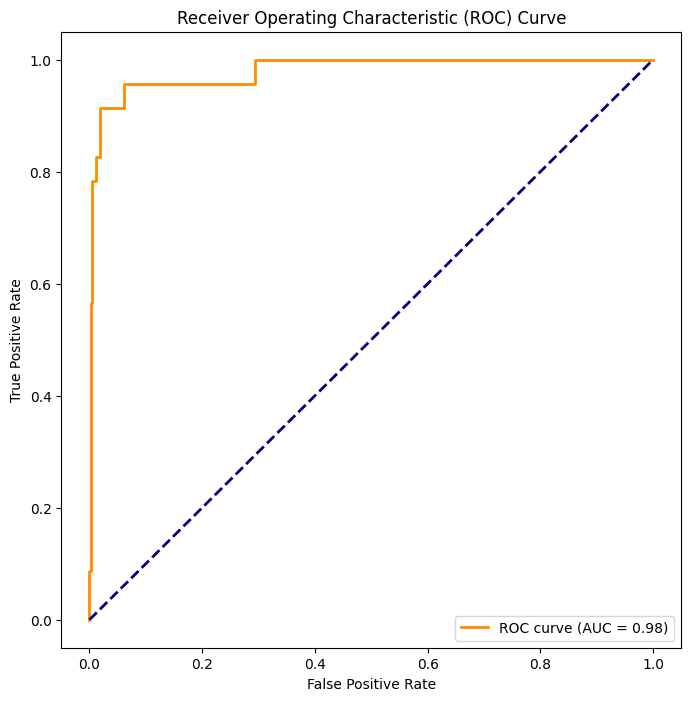

In [22]:
# Predict probabilities on the validation set with the best iteration
y_val_proba = best_model.predict(dvalid)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_val, y_val_proba)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Best thresholds acc. to ROC AUC

In [23]:
# best threshold according to ROC AUC without consideration for bias (just yet)

# get tresholds
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# Find optimal threshold based on Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Use the optimal threshold for predictions
y_val_pred_optimal = (y_val_proba > optimal_threshold).astype(int)

# Outcomes for privileged and unprivileged groups

In [24]:
# Add the gender information back to X_val
X_val['borrowers.gender'] = val_data['borrowers.gender']

# Create masks for subgroups
mask_female = (X_val['borrowers.gender'] == 1)
mask_male = (X_val['borrowers.gender'] == 0)

# Calculate TPR and TNR for each subgroup
def calculate_tpr_tnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    return tpr, tnr

# Apply the optimal threshold to get binary predictions
y_val_pred_optimal = (y_val_proba > optimal_threshold).astype(int)

# Calculate TPR and TNR for each subgroup
tpr_female, tnr_female = calculate_tpr_tnr(y_val[mask_female], y_val_pred_optimal[mask_female])
tpr_male, tnr_male = calculate_tpr_tnr(y_val[mask_male], y_val_pred_optimal[mask_male])

# Print the results
print("Gender Female:")
print(f"TPR: {tpr_female:.4f}, TNR: {tnr_female:.4f}\n")

print("Gender Male:")
print(f"TPR: {tpr_male:.4f}, TNR: {tnr_male:.4f}\n")

Gender Female:
TPR: 0.9412, TNR: 0.9477

Gender Male:
TPR: 0.8333, TNR: 0.9052



# Classification report

In [25]:
# Apply the optimal threshold to get binary predictions
y_val_pred_optimal = (y_val_proba > optimal_threshold).astype(int)

# Print the classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_optimal))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       976
           1       0.26      0.91      0.40        23

    accuracy                           0.94       999
   macro avg       0.63      0.93      0.69       999
weighted avg       0.98      0.94      0.95       999



# Enforcing Equalized Odds

In [26]:
# Add gender back to use with EqOddsPostprocessing
X_val['borrowers.gender'] = val_data['borrowers.gender']

# Reassemble X_val and y_val
reassembled_val = pd.DataFrame(X_val, columns=X_val.columns)
reassembled_val['status'] = y_val

# Assemble a dataset with X_val and the predictions based on it
X_val_and_pred = pd.DataFrame(X_val, columns=X_val.columns)
X_val_and_pred['status'] = y_val_pred_optimal

In [47]:
# Create a StandardDataset from the val set and the true values
dataset_true = StandardDataset(reassembled_val, label_name='status', favorable_classes=[0], protected_attribute_names=['borrowers.gender'], privileged_classes=[[1]])

# Create a StandardDataset from the val set and the predictions
dataset_pred = StandardDataset(X_val_and_pred, label_name='status', favorable_classes=[0], protected_attribute_names=['borrowers.gender'], privileged_classes=[[1]])

# Initialize EqOddsPostprocessing
unprivileged_groups = [{'borrowers.gender': 0}]
privileged_groups = [{'borrowers.gender': 1}]
postprocessor = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

# Apply EqOddsPostprocessing to get the adjusted predictions
postprocessor.fit(dataset_true, dataset_pred)

# Get the adjusted labels from the transformed dataset
dataset_pred_after = postprocessor.predict(dataset_pred)

# Get the adjusted labels from the transformed dataset
y_pred_after = dataset_pred_after.labels.ravel()

# Evaluate outcomes and performances with Equalized Odds Enforcement

# Outcomes

In [46]:
# Calculate TPR and TNR for each subgroup
tpr_female, tnr_female = calculate_tpr_tnr(y_val[mask_female], y_pred_after[mask_female])
tpr_male, tnr_male = calculate_tpr_tnr(y_val[mask_male], y_pred_after[mask_male])

# Print the results
print("Gender Female:")
print(f"TPR: {tpr_female:.4f}, TNR: {tnr_female:.4f}\n")

print("Gender Male:")
print(f"TPR: {tpr_male:.4f}, TNR: {tnr_male:.4f}\n")

Gender Female:
TPR: 0.9412, TNR: 0.9477

Gender Male:
TPR: 0.8333, TNR: 0.9052



# Classification report

In [22]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_after))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       976
           1       0.26      0.91      0.40        23

    accuracy                           0.94       999
   macro avg       0.63      0.93      0.69       999
weighted avg       0.98      0.94      0.95       999

